## Dog Cat Classification

### 1 - Package import 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
import tensorflow.keras.layers as tfl

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### 2 - Data Import

In [2]:
train_path = '../input/dogs-vs-cats/train.zip'
test_path = '../input/dogs-vs-cats/test1.zip'

destination = '/kaggle/files/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)

In [3]:
train = pd.DataFrame({'file': os.listdir('/kaggle/files/images/train')})

categories = []
for i in os.listdir('/kaggle/files/images/train'):
    if 'dog' in i:
        categories.append(1)
    else:
        categories.append(0)
        
train['categories'] = categories

test = pd.DataFrame({'file': os.listdir('/kaggle/files/images/test1')})

### 3 - See an example 

<class 'numpy.ndarray'>
(255, 319, 3)
<class 'tuple'>


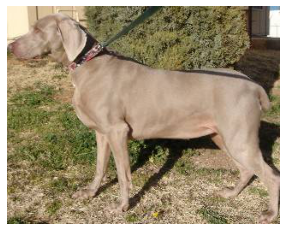

In [4]:
def example_im(index):
    '''
    Function to display an example image.
    
    index -- which image in the training set. 
    '''
    im = plt.imread('/kaggle/files/images/train/'+str(train['file'][index]))

    print(type(im))
    print(im.shape)
    print(type(im.shape))
    
    plt.imshow(im)
    plt.axis('off')
example_im(1)

### 4 - Data Preparation 

In [5]:
train['categories'].value_counts()

1    12500
0    12500
Name: categories, dtype: int64

For our data, we have same number of cats and dogs and training data.

In [6]:
train.shape

(25000, 2)

The numeric varaible in `categories` columns is mapped to string for later image generation

The training data is not a particularly small dataset so we can use `10%` of its data as a `cross validation set`, and `random_state` is set to be 0 for reproductivity.

In [7]:
train['categories'] = train['categories'].replace({0: 'cat', 1: 'dog'})
train_set, val_set = train_test_split(train, test_size=0.1, random_state = 0)

In [8]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

batch_size = 64

train_generator = train_gen.flow_from_dataframe(
    dataframe = train_set,
    directory = destination + '/train/', # file path format
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)


validation_generator = val_gen.flow_from_dataframe(
    dataframe = val_set,
    directory = destination + '/train/',
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


Found 22500 validated image filenames belonging to 2 classes.


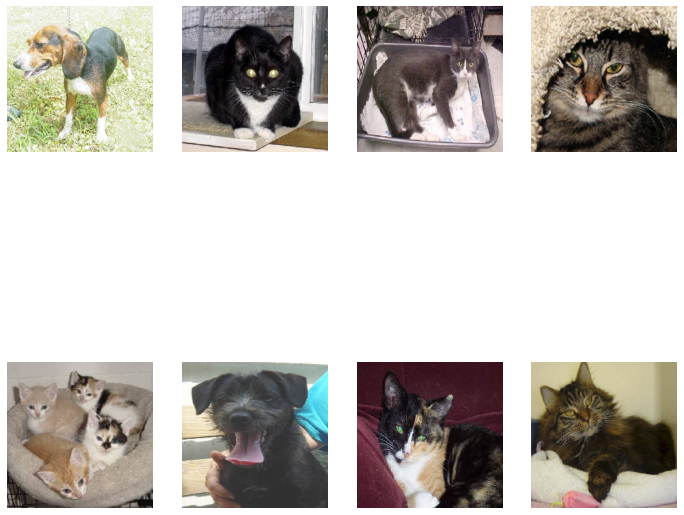

In [9]:
def mini_batch_example_plot(df):

    example_generator = train_gen.flow_from_dataframe(
        dataframe = df,
        directory = destination + '/train/',
        x_col = 'file',
        y_col = 'categories',
        class_mode = 'categorical',
        target_size = (224,224)
    )
    
    fig, ax  = plt.subplots(2,4,figsize=(12, 12))
    ax = ax.flatten()
    
    for i in range(8):
        X, Y = next(example_generator)
        image = X[0]
        ax[i].imshow(image)
        ax[i].axis('off')
    
    
mini_batch_example_plot(train_set)

### 5 - CNN model construction

In [10]:
from numpy.random import seed
seed(1)

tf.random.set_seed(2)

In [11]:
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [12]:
# set constants
(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) = (224,224,3)
IMAGE_SIZE  = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE = (224,224,3)

In [13]:
def shallow_CNN_Model(image_shape, augmentation = False):
    '''
    This creates a shallow CNN model, the structure uses the idea from VGG-16
    '''
    if (augmentation == True):
        model = tf.keras.Sequential([RandomFlip("horizontal",input_shape = image_shape),
                   RandomRotation(0.1)])
    else: 
        model = tf.keras.Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = image_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

In [14]:
model = shallow_CNN_Model(IMAGE_SHAPE)
model_augmented = shallow_CNN_Model(IMAGE_SHAPE,True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2021-12-14 06:08:27.604564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 06:08:27.701207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 06:08:27.702501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 06:08:27.704302: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      3

### 6 - Early stopping after seeing no decrease in loss over 5 epoches

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=5)

In [16]:
def model_fitting(model, callbacks, epochs):
    '''
    This is a function used to fit generator, with customized input 
    model, callbacks, and epochs. 
    '''
    return model.fit_generator(
        train_generator, 
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = val_set.shape[0]//64,
        steps_per_epoch = train_set.shape[0]//64,
        callbacks = callbacks 
    )
    

In previous test, the dataset not being augmented performs worse than augmented dataset on validation set, showing a sign of overfitting in training set.  

In [17]:
# history_epoch50 = model_fitting(model, [earlystop], epochs = 50)

In [18]:
history_epoch50_augmented = model_fitting(model_augmented, [earlystop], epochs = 50)

2021-12-14 06:08:31.736004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-14 06:08:34.409103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 128s 337ms/step - loss: 0.7394 - accuracy: 0.6424 - val_loss: 0.8681 - val_accuracy: 0.5076
Epoch 2/50
351/351 [==============================] - 114s 324ms/step - loss: 0.5347 - accuracy: 0.7319 - val_loss: 1.6357 - val_accuracy: 0.4964
Epoch 3/50
351/351 [==============================] - 116s 330ms/step - loss: 0.4645 - accuracy: 0.7799 - val_loss: 0.4370 - val_accuracy: 0.8093
Epoch 4/50
351/351 [==============================] - 116s 330ms/step - loss: 0.3997 - accuracy: 0.8169 - val_loss: 0.6494 - val_accuracy: 0.7544
Epoch 5/50
351/351 [==============================] - 117s 334ms/step - loss: 0.3634 - accuracy: 0.8387 - val_loss: 0.7851 - val_accuracy: 0.7244
Epoch 6/50
351/351 [==============================] - 115s 328ms/step - loss: 0.3239 - accuracy: 0.8609 - val_loss: 0.3505 - val_accuracy: 0.8562
Epoch 7/50
351/351 [==============================] - 117s 332ms/step - loss: 0.2990 - accuracy: 0.8713 - val_loss: 0.8851 - val_accura

In [19]:
model_augmented.save_weights('model_augmented_weights.h5')

In [20]:

def plotting_loss(history,upper_bound):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, upper_bound, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, upper_bound, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


In [21]:
# plotting_loss(history_epoch50, 50)

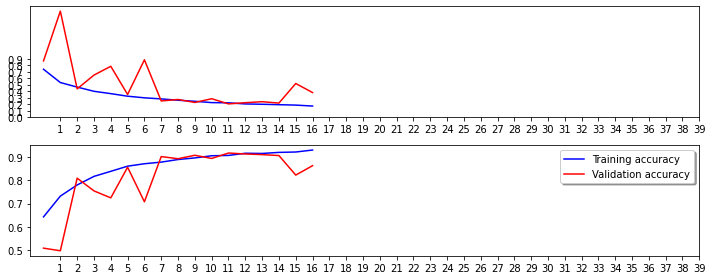

In [22]:
plotting_loss(history_epoch50_augmented, 40)

Using functional API for easier operation on last few layers for transfer learning.

In [23]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [24]:
input_shape = (224,224, 3)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def transfer_learning(model,image_shape=input_shape, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function

    Returns:
        tf.keras.model
    '''
    if model == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                       include_top=False, 
                                                       weights='imagenet') # From imageNet
    if model == 'VGG':
        base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                                    weights="imagenet", 
                                                    include_top=False)

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape = input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units = 2)(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [25]:
model_trans_VGG = transfer_learning('VGG',(224,224,3), data_augmenter())
base_learning_rate = 0.001
model_trans_VGG.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_trans_Mobile = transfer_learning('MobileNetV2',(224,224,3), data_augmenter())
base_learning_rate = 0.001
model_trans_Mobile.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_trans_VGG.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
________________________________________________________________

In [26]:
model_trans_Mobile.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0   

In [27]:
history_trans_VGG = model_fitting(model_trans_VGG, [earlystop], epochs = 20)

Epoch 1/20
351/351 [==============================] - 126s 343ms/step - loss: 0.6984 - accuracy: 0.4982 - val_loss: 0.6930 - val_accuracy: 0.5072
Epoch 2/20
351/351 [==============================] - 116s 329ms/step - loss: 0.6949 - accuracy: 0.5024 - val_loss: 0.6927 - val_accuracy: 0.5084
Epoch 3/20
351/351 [==============================] - 117s 334ms/step - loss: 0.6945 - accuracy: 0.4999 - val_loss: 0.6930 - val_accuracy: 0.5080
Epoch 4/20
351/351 [==============================] - 115s 328ms/step - loss: 0.6942 - accuracy: 0.4964 - val_loss: 0.6928 - val_accuracy: 0.5080
Epoch 5/20
351/351 [==============================] - 116s 331ms/step - loss: 0.6935 - accuracy: 0.5094 - val_loss: 0.6926 - val_accuracy: 0.5076
Epoch 6/20
351/351 [==============================] - 116s 331ms/step - loss: 0.6945 - accuracy: 0.5031 - val_loss: 0.6924 - val_accuracy: 0.5505
Epoch 7/20
351/351 [==============================] - 117s 333ms/step - loss: 0.6936 - accuracy: 0.5031 - val_loss: 0.6922 -

In [28]:
history_trans_Mobile = model_fitting(model_trans_Mobile, [earlystop], epochs = 20)

Epoch 1/20
351/351 [==============================] - 113s 311ms/step - loss: 0.7111 - accuracy: 0.5134 - val_loss: 0.6817 - val_accuracy: 0.5701
Epoch 2/20
351/351 [==============================] - 112s 318ms/step - loss: 0.6900 - accuracy: 0.5459 - val_loss: 0.6895 - val_accuracy: 0.5264
Epoch 3/20
351/351 [==============================] - 112s 319ms/step - loss: 0.6849 - accuracy: 0.5568 - val_loss: 0.6740 - val_accuracy: 0.5841
Epoch 4/20
351/351 [==============================] - 109s 311ms/step - loss: 0.6782 - accuracy: 0.5719 - val_loss: 0.6770 - val_accuracy: 0.5781
Epoch 5/20
351/351 [==============================] - 109s 312ms/step - loss: 0.6789 - accuracy: 0.5707 - val_loss: 0.6690 - val_accuracy: 0.5938
Epoch 6/20
351/351 [==============================] - 116s 329ms/step - loss: 0.6756 - accuracy: 0.5794 - val_loss: 0.6675 - val_accuracy: 0.5913
Epoch 7/20
351/351 [==============================] - 114s 325ms/step - loss: 0.6757 - accuracy: 0.5722 - val_loss: 0.6678 -

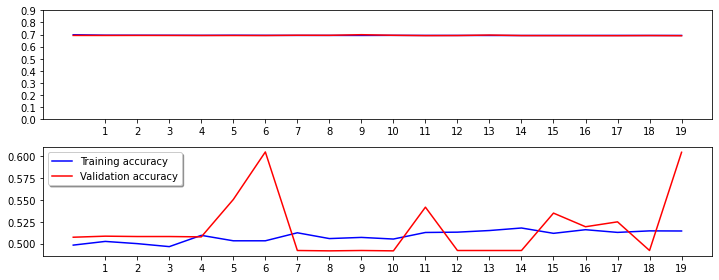

In [29]:
plotting_loss(history_trans_VGG, 20)

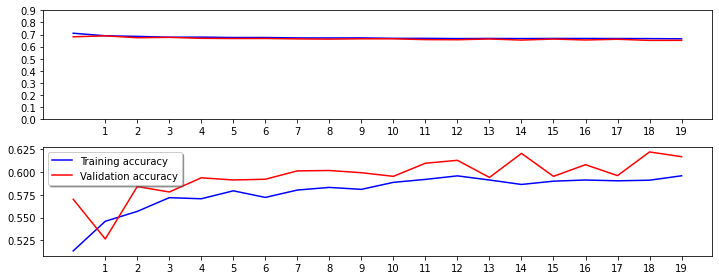

In [30]:
plotting_loss(history_trans_Mobile, 20)

### Fine-tuning the Model

Unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it.

In [31]:

submission(model_augmented)

NameError: name 'submission' is not defined